[View in Colaboratory](https://colab.research.google.com/github/Hrishi5/RRT_RMP_Project/blob/master/RapidlyExploringRandomTrees.ipynb)

## **Rapidly Exploring Random Trees - Hrishikesh Deshpande**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib as mpl

In [0]:
class TreeNode():
    
    def __init__(self,data,parent=None):
        self.parent = parent
        self.data = data ;
        self.child = [] ;
        
    def addChild(self,treeNode):
        self.child.append(treeNode)
    
    def removeLastChild(self):
        return self.child.pop() ;
    
    def removeChildByIndex(self,index):
        return self.child.pop(len(self.child)-1-index)

In [0]:
shape_dict_str = {'1':'square','2':'rectangle','3':'triangle'}
shape_dict = {1:'square',2:'rectangle',3:'triangle'}
vert_dict = {'0':'A','1':'B','2':'C','3':'D'}
class obstacle():
    
    def __init__(self,t,x,y,theta,w,h):
        self.typ = t
        self.xa = x
        self.ya = y
        self.w = w
        self.h = h
        self.theta = (theta * np.pi)/180
        self.thetad = theta
        self.shape = shape_dict[t]
        self.vertices = []
        self.vertices.append((self.xa,self.ya))
        self.vert_x = []
        self.vert_y=[]
        self.get_vertices()
    
    def __str__(self):
        return self.shape + ' ' + str(self.vertices)
    
    def sign(self,va, vb, vc):
        return (va[0] - vc[0]) * (vb[1] - vc[1]) - (vb[0] - vc[0]) * (va[1] - vc[1])
    
    def collidesWith(self,p):
        if self.typ == 3:
            b1 = self.sign(p, (self.xa,self.ya), (self.xb,self.yb)) < 0.0
            b2 = self.sign(p, (self.xb,self.yb), (self.xc,self.yc)) < 0.0
            b3 = self.sign(p, (self.xc,self.yc), (self.xa,self.ya)) < 0.0
            return ((b1 == b2) and (b2 == b3))
        else:
            obs_path = mpl.path.Path([[self.xa,self.ya],[self.xb,self.yb],[self.xc,self.yc],[self.xd,self.yd]])
            isInside = obs_path.contains_points([[p[0],p[1]]])
            return isInside[0] 
        
    def get_vertices(self):
        if self.typ !='3':
            self.xb = self.xa + self.w*np.cos(self.theta)
            self.yb = self.ya + self.w*np.sin(self.theta)
            self.vertices.append((self.xb,self.yb))
            self.xd = self.xa - self.h*np.sin(self.theta)
            self.yd = self.ya + self.h*np.cos(self.theta)
            self.xc = self.xd + self.w*np.cos(self.theta)
            self.yc = self.yd + self.w*np.sin(self.theta)
            self.vertices.append((self.xc,self.yc))
            self.vertices.append((self.xd,self.yd))
            self.vert_y.append(self.ya)
            self.vert_y.append(self.yb)
            self.vert_y.append(self.yc)
            self.vert_y.append(self.yd)
            self.vert_x.append(self.xa)
            self.vert_x.append(self.xb)
            self.vert_x.append(self.xc)
            self.vert_x.append(self.xd)
        else:
            self.h = self.w * np.sin(np.pi/3)
            alpha = self.thetad + 60
            alpha = (alpha*np.pi)/180
            self.xb = self.xa + self.w * np.cos(self.theta)
            self.yb = self.ya + self.w * np.cos(self.theta)
            self.vertices.append((self.xb,self.yb))
            self.xc = self.xa + self.w * np.cos(alpha)
            self.yc = self.xa + self.w * np.sin(alpha)
            self.vertices.append((self.xc,self.yc))
            self.vert_y.append(self.ya)
            self.vert_y.append(self.yb)
            self.vert_y.append(self.yc)
            self.vert_x.append(self.xa)
            self.vert_x.append(self.xb)
            self.vert_x.append(self.xc)
        
    
        
            
        
        
        

In [0]:
class configuration():
    def __init__(self,xi,yi,thetai,pvel,pphi,dist,index,pindex,xp=None,yp=None):
        self.x = xi;
        self.y = yi;
        self.theta = thetai;
        self.x_parent = xp;
        self.y_parent = yp;
        self.theta_parent = thetai;
        self.parent_velocity = pvel; #This is the velocity at the parent node required to reach current node in the tree
        self.parent_steering_angle = pphi; #This is the steering angle at the parent node required to reach current node in the tree. 
        self.distance = dist;
        self.index = index; 
        self.parent_index = pindex;
        

In [0]:
def generate_random_number(ll,ul):
    return int(np.round(np.random.uniform(ll,ul,1)[0]))


def generateRandomWorkspace(size_x,size_y):
    n_obstacles = generate_random_number(0,10)
    print(n_obstacles)
    obstacles = []
    w = 10 ;
    h = 5
    
    for i in range(n_obstacles):
        t = generate_random_number(1,3)
        x = generate_random_number(0,size_x)
        y=generate_random_number(0,size_y)
        theta = generate_random_number(0,90)
        obstacles.append(obstacle(t,x,y,theta,w,h))
    return obstacles

def plotWorkspace(obstacles):
    for i in obstacles:
        plt.subplot(2,1,2)
        plt.plot(i.vert_x,i.vert_y)
    plt.show()

In [0]:
def generateRandomStartGoalPoints(max_vert,min_vert):
    start = [np.random.uniform(-1,1,1),np.random.uniform(min_vert,max_vert,1)]
    goal = [np.random.uniform(min_vert,max_vert,1),np.random.uniform(min_vert,max_vert,1)]
    print(start,goal)
    plt.scatter(start[0],start[1],c='red')
    plt.scatter(goal[0],goal[1],c='green')
    #plt.scatter(verts[0][0][0],verts[0][0][1],c='yellow')
    plt.show()
    return start,goal 
  

In [8]:

size_x = int(input('Input the width of the workspace(atleast 200)')) ;
size_y = int(input('Input height of workspace(atleast 200)'))
if size_x < 200:
    size_x = 200
if size_y < 200:
    size_y = 200


Input the width of the workspace(atleast 200)600
Input height of workspace(atleast 200)600


In [9]:
rand_workspace = input('Do you want to randomly generate workspace ? (Y/N)')
if rand_workspace == 'Y' or rand_workspace == 'y':
    obstacles = generateRandomWorkspace(size_x,size_y)
else:
    n_obstacles = input('please enter the number of obstacles(r for random number)')
    if n_obstacles == 'r' or n_obstacles =='R':
        n_obstcles = np.random.uniform(5,20,1)[0]
    print('Input the type of obstacle')
    print('1.Square\n2.Rectangle\n3.Triangle\n4.Random')
    obstacles = []
    for i in range(n_obstacles):
        t = int(input('Enter type of obstacle ' + (i+1)))
        if t==4:
            t = np.random.uniform(1,3,1)[0]
        cx = float(input('input x coordinate') )
        cy = float(input('input y coordinate'))
        ctheta = float(input('input orientation of obstacle'))
    
    


Do you want to randomly generate workspace ? (Y/N)Y
6


In [0]:
def getRandomConfiguration(x_max,x_min,y_max,y_min):
    xr = round(generate_random_number(ll=x_min,ul=x_max))
    yr = round(generate_random_number(ll=y_min,ul=y_max));
    theta_rand = generate_random_number(2*np.pi,np.pi/6)
    return xr,yr,theta_rand ;

In [0]:
def getEuclideanDistance(x1,y1,x2,y2):
    d2 = np.square(x2-x1) + np.square(y2-y1)
    return np.sqrt(d2)
    

In [0]:
def getEuclideanDistanceWithAngle(x1,y1,x2,y2,t1,t2):
    pi = np.pi
    d2 = np.square(x2-x1) + np.square(y2-y1) + min([(t1 - t2)**2, (t1 - t2 - pi)**2, (t1-t2 + pi)**2])
    return np.sqrt(d2)
     

In [0]:
def detect_collision(x,y,obstacles):
    p = (x,y)
    for o in obstacles:
        if o.collidesWith(p):
            return True
    return False
            
    

In [0]:
def validateTheta(theta_new):
    pi = np.pi
    if theta_new < 0 :
            theta_new = 2*pi - abs(theta_new);
    if theta_new > 2*pi :
            while theta_new > 2*pi :
                theta_new = theta_new - 2*pi
    return theta_new

In [0]:
from matplotlib import patches
def plot_obstacles(obstacles):
    print(obstacles)
    for o in obstacles:
        if o.typ != 3:
            t = plt.Rectangle(xy=[o.xa,o.ya],width=o.w,height=o.h)
        else:
            t = plt.Polygon([[o.xa,o.ya],[o.xb,o.yb],[o.xc,o.yc]])
        plt.gca().add_patch(t)

In [0]:
start_x = 10
start_y = 10
goal_x = 20
goal_y = 20
start_theta = 0.001
root = TreeNode((start_x,start_y))
root.data = configuration(xi=start_x,yi=start_y,thetai=start_theta,pvel=0,pphi=0,index=0,pindex=0,dist=0)


In [0]:
car_length = 3
steering_angle = 20*np.pi/180 #degrees
v = 3
start_x = 100
start_y = 100
start_theta = 0;
goal_x = 500
goal_y = 400
goal_theta = 90*np.pi/180;
dt = 0.1

[<__main__.obstacle object at 0x7fa0d27e4e10>, <__main__.obstacle object at 0x7fa0d27e41d0>, <__main__.obstacle object at 0x7fa0d27e4eb8>, <__main__.obstacle object at 0x7fa0d27e44a8>, <__main__.obstacle object at 0x7fa0d27e4630>, <__main__.obstacle object at 0x7fa0d27e4240>]


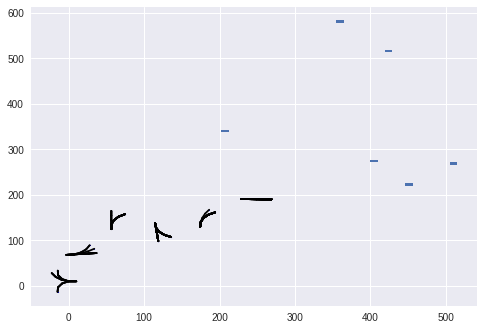

In [23]:
tree=[root]
distances = []
step_size = 5
v = 10
l=1
plot_obstacles(obstacles)
for step in range(7):
            current_min_dist = 0
            parent_index = 0
            path=[]

            new_node_array = []
            collision = True
            while collision:
                xr,yr,tr = getRandomConfiguration(size_x,0,size_y,0)
                collision = detect_collision(xr,yr,obstacles)
            
            dt = 1
            x,y,t = tree[0].data.x , tree[0].data.y , tree[0].data.theta
            current_min_dist = getEuclideanDistanceWithAngle(x,y,xr,yr,t,tr)
            for i in range(len(tree)):
                x,y,t = tree[i].data.x , tree[i].data.y , tree[i].data.theta
                d = getEuclideanDistanceWithAngle(x,y,xr,yr,t,tr)
                if current_min_dist > d:
                    current_min_dist = d
                    parent_index = i
                xn,yn,tn = tree[parent_index].data.x , tree[parent_index].data.y,tree[parent_index].data.theta
                cphi = -steering_angle
                cvel = -v
                path = []
                path.append((xn,yn,tn))
                calc_path = True
                while cvel <= v:
                #for cvel in [-v, -v/2 , -v/4 , -v/8 , v/8 , v/4 , v/2 , v]:
                    while cphi<= steering_angle:
                    #for cphi in [steering_angle-np.pi/2 , steering_angle - np.pi/4, steering_angle - np.pi/6 , steering_angle - np.pi/8 , steering_angle]:
                        for j in range(1,10):
                            path.append(())
                            xj = path[j-1][0] + cvel * np.cos(path[j-1][2])*dt
                            yj = path[j-1][1] + cvel*np.sin(path[j-1][2])*dt
                            tj = path[j-1][2] + (cvel/car_length)*np.tan(cphi)*dt
                            path[j] = (xj,yj,tj)
                        
                        
                        new_dist = getEuclideanDistanceWithAngle(path[j][0],path[j][1],xr,yr,path[j][2],tr)
                        new_node_array.append([new_dist, cvel, cphi, path[j][0], path[j][1], path[j][2]])
                        cphi+=0.05
                    if cvel + 5 > -30 and cvel + 5 < 30:
                        cvel = 30;
                    else:
                        cvel+=5
                    
                    cphi = -steering_angle
                    new_node_array_t = np.array(new_node_array)
                    current_min_dist_i = np.argmin(new_node_array_t[:,0])
                    cmin =new_node_array_t[current_min_dist_i,0]
                    xnew,ynew,tnew = new_node_array[current_min_dist_i][3],new_node_array[current_min_dist_i][4],new_node_array[current_min_dist_i][5]
                    tnew = validateTheta(tnew)
                    npvel = new_node_array[current_min_dist_i][1]
                    npsteeringangle = new_node_array[current_min_dist_i][2]
                    dnew = configuration(xi = xnew , yi = ynew , thetai=tnew,pvel=npvel,pphi=npsteeringangle,dist=cmin,index=step,pindex=parent_index)
                    dnew.x_parent = xn
                    dnew.y_parent = yn
                    node = TreeNode(data=dnew)
                    tree.append(node)

                   
                    path = []
                    path.append((xn,yn,tn))
                    for k in range(1,step_size):
                        path.append(())
                        xk = path[k-1][0] + npvel * np.cos(path[k-1][2])*dt
                        yk = path[k-1][1] + npvel*np.sin(path[k-1][2])*dt
                        tk = path[k-1][2] + (npvel/car_length)*np.tan(npsteeringangle)*dt
                        path[k] = (xk,yk,tk)
                        
                        
                        

                    plt.scatter(path[k][0], path[k][1], s=0.5,c='b');
                    lines = []
                    for s in range (1,len(path)):
                            #lines.append([(path[s][0],path[s][1]),(path[s-1][0],path[s-1][1])])
                            plt.plot([path[s][0],path[s-1][0]],[path[s][1],path[s-1][1]],c='black')
                    #lc = mpl.collections.LineCollection(lines)
                    #fig,ax = plt.subplots()
                    #ax.add_collection(lc)
                    #ax.autoscale()
                    distance_threshold = 30
                    orientation_threshold = 10*np.pi/180
                    distance_to_goal = getEuclideanDistance(xnew,ynew,goal_x,goal_y) 
                    if distance_to_goal <= distance_threshold and ( abs(tnew - goal_theta)<=orientation_threshold or abs(tnew - goal_theta - np.pi) <=orientation_threshold):
                        print('Final Configuration Near the Goal Configuration is:')
                        x_coordinate = xnew
                        y_coordinate = ynew
                        orientation_in_degrees = tnew*180/np.pi
                        break

                    index = len(tree)-1;
                    parent_index = tree[index].data.parent_index;

                    if getEuclideanDistance(tree[index].data.x,tree[index].data.y,goal_x,goal_y) <= distance_threshold:
                        while parent_index != 0:
                            path = [tree[index].data.x_parent, tree[index].data.y_parent, tree[index].data.theta_parent ];
                            parent_vel_new = tree[index].data.parent_velocity
                            parent_steering_angle_new = tree[index].data.parent_steering_angle

                        for l in range(1,step_size):
                            path.append(())
                            xl = path[l-1][0] + parent_vel_new*np.cos(path[l-1][3])*dt;
                            yl = path[l-1][1] + parent_vel_new*np.sin(path[l-1][3])*dt;
                            tl = path[l-1][2] + (parent_vel_new/L)*np.tan(parent_steering_angle_new)*dt;
                            path[l] = (xl,yl,tl)
                        for j in range(1,len(path)):
                            #pygame.line(screen,white,(path[j][0], path[j-1][0]), (path[j][1], path[j-1][1]))
                            index = parent_index;
                            parent_index = tree[index].data.parent_index;
                   

In [0]:
plt.show()